# E-commerce Sample ETL – November

This notebook prepares a **100 k-row sample** for loading into BigQuery.  
Steps implemented:
1. Data profiling  
2. Schema enforcement & typing  
3. Cleaning & imputation  
4. De-duplication & filtering  
5. Feature engineering & enrichment  
6. Validation tests  
7. Export cleaned sample (`CSV`)

In [37]:
# 0️⃣ Imports & settings
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", 120)

INPUT_PATH  = "D:\Digital_Analytics\sample_Nov.csv"
CSV_OUT     = "D:\Digital_Analytics\Cleaned data\Cleaned_Nov.csv"

## 1  Data profiling

Rows: 100000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   event_time     100000 non-null  datetime64[ns, UTC]
 1   event_type     100000 non-null  object             
 2   product_id     100000 non-null  int64              
 3   category_id    100000 non-null  int64              
 4   category_code  66914 non-null   object             
 5   brand          84701 non-null   object             
 6   price          100000 non-null  float64            
 7   user_id        100000 non-null  int64              
 8   user_session   100000 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(4)
memory usage: 6.9+ MB


,count,mean,std,min,25%,50%,75%,max
product_id,100000.0,1.096056e+07,1.211714e+07,1.000978e+06,1.005211e+06,5.100816e+06,1.590233e+07,6.050000e+07
category_id,100000.0,2.057821e+18,1.948642e+16,2.053014e+18,2.053014e+18,2.053014e+18,2.053014e+18,2.180737e+18
price,100000.0,2.837066e+02,3.437562e+02,0.000000e+00,6.693000e+01,1.660300e+02,3.522100e+02,2.574070e+03
user_id,100000.0,5.355688e+08,2.032069e+07,2.752567e+08,5.159393e+08,5.317645e+08,5.551337e+08,5.663693e+08


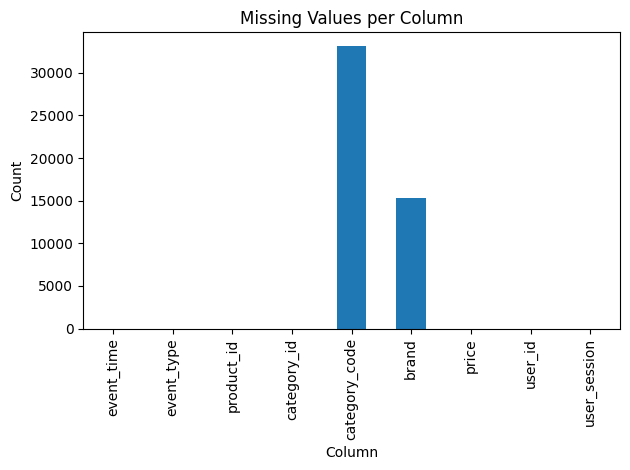

In [38]:
# 2️⃣ Missing Values per Column
df = pd.read_csv(INPUT_PATH, parse_dates=["event_time"], low_memory=False)
print("Rows:", len(df))
df.info()

# basic stats
display(df.describe().T)
plt.figure()
df.isna().sum().plot(kind="bar")
plt.title("Missing Values per Column")
plt.xlabel("Column")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

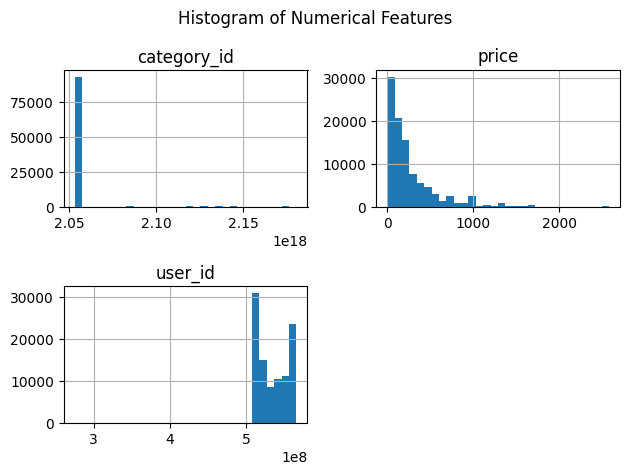

In [45]:
# Identify all numeric columns in the cleaned DataFrame
num_cols = df.select_dtypes(include=["number"]).columns

# Plot histograms for each numeric column to see their distributions
plt.figure()
df[num_cols].hist(bins=30)
plt.suptitle("Histogram of Numerical Features")
plt.tight_layout()
plt.show()


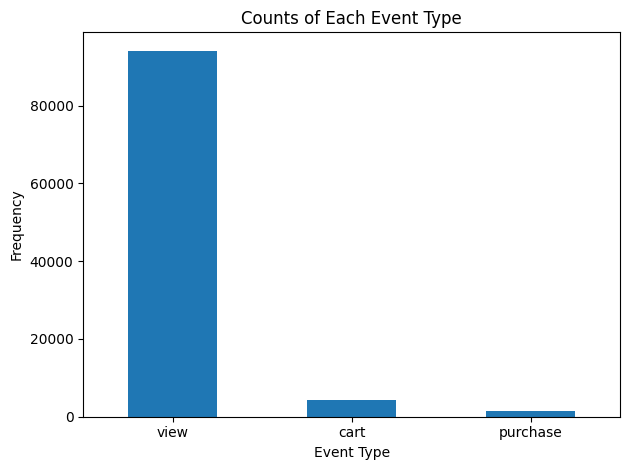

In [48]:
# Compute counts for each event type
event_counts = df['event_type'].value_counts()

# Plot as a simple bar chart
plt.figure()
event_counts.plot(kind='bar')
plt.title("Counts of Each Event Type")
plt.xlabel("Event Type")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [41]:
# null counts
nulls = df.isna().sum().sort_values(ascending=False)
display(nulls[nulls>0])

# cardinality check for object / category columns
cat_cols = [c for c in df.columns if df[c].dtype=="object"]
card = {c: df[c].nunique() for c in cat_cols}
display(pd.Series(card).sort_values(ascending=False))


category_code    33086
brand            15299
dtype: int64

user_session     26807
brand             1583
category_code      121
event_type           3
dtype: int64

## 2  Schema enforcement & typing

In [42]:
# expected types for key columns – adjust to match your schema
schema = {
    "timestamp": "datetime64[ns]",
    "user_id"  : "Int64",
    "session_id": "string",
    "event_type": "category",
    "product_id": "string",
    "price"     : "float64",
    "quantity"  : "Int64"
}

# rename columns to snake_case
df.columns = df.columns.str.lower().str.replace(" ", "_")

# cast types
for col, dtype in schema.items():
    if col in df.columns:
        df[col] = df[col].astype(dtype)

In [53]:
print(df.columns.tolist())


['event_time', 'event_type', 'product_id', 'category_id', 'category_code', 'brand', 'price', 'user_id', 'user_session']


## 3  Cleaning & imputation

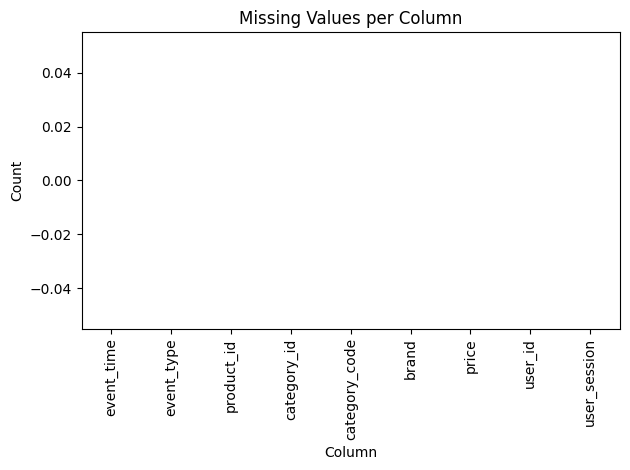

In [44]:
# drop exact duplicates
df = df.drop_duplicates()

# drop if <5 % missing, else fill
threshold = 0.05 * len(df)
for col in df.columns:
    n_missing = df[col].isna().sum()
    if n_missing == 0:
        continue
    if n_missing < threshold:
        df = df[df[col].notna()]
    else:
        if pd.api.types.is_numeric_dtype(df[col]):
            df[col] = df[col].fillna(0)
        else:
            df[col] = df[col].fillna("unknown")
#after cleaning
plt.figure()
df.isna().sum().plot(kind="bar")
plt.title("Missing Values per Column")
plt.xlabel("Column")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## 4  De-duplication & filtering

In [ ]:
# keep last event per session as example business rule
if "session_id" in df.columns:
    df = df.sort_values("timestamp").drop_duplicates("session_id", keep="last")

# filter logical errors
if "price" in df.columns:
    df = df[df["price"] >= 0]
if "quantity" in df.columns:
    df = df[df["quantity"] >= 0]

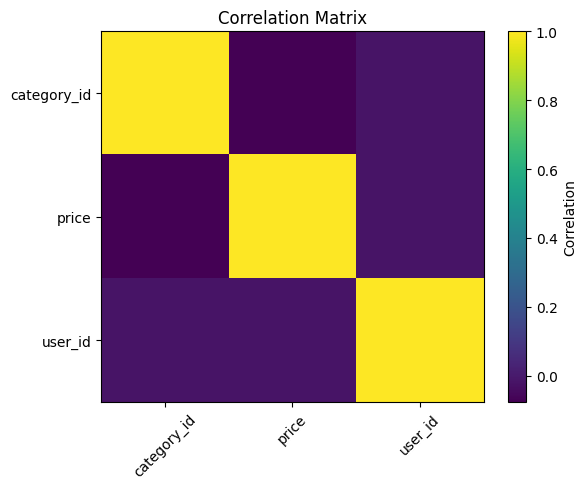

In [50]:
# Compute correlation matrix for numeric fields
corr = df[num_cols].corr()

# Display the correlation matrix as a heatmap
plt.figure(figsize=(6, 5))
plt.imshow(corr, aspect="auto", cmap="viridis")
plt.colorbar(label="Correlation")
plt.title("Correlation Matrix")
plt.xticks(range(len(num_cols)), num_cols, rotation=45)
plt.yticks(range(len(num_cols)), num_cols)
plt.tight_layout()
plt.show()


In [54]:
print(df.columns.tolist())


['event_time', 'event_type', 'product_id', 'category_id', 'category_code', 'brand', 'price', 'user_id', 'user_session']


## 5  Feature engineering & enrichment

In [59]:
# derived flags
if "event_type" in df.columns:
    df["is_purchase"] = (df["event_type"] == "purchase")

# time features
df["hour_of_day"] = df["event_time"].dt.hour
df["day_of_week"] = df["event_time"].dt.dayofweek
df["is_weekend"]  = df["day_of_week"].isin([5,6])

# session-level agg example (adds duration per session)
if "session_id" in df.columns:
    session_span = (
        df.groupby("session_id")["timestamp"]
          .agg(["min", "max"])  # first and last event per session
          .assign(duration_s=lambda x: (x["max"] - x["min"]).dt.total_seconds()) # Diffrence between first and last in seconds
    )
    df = df.merge(session_span["duration_s"], left_on="session_id", right_index=True, how="left")

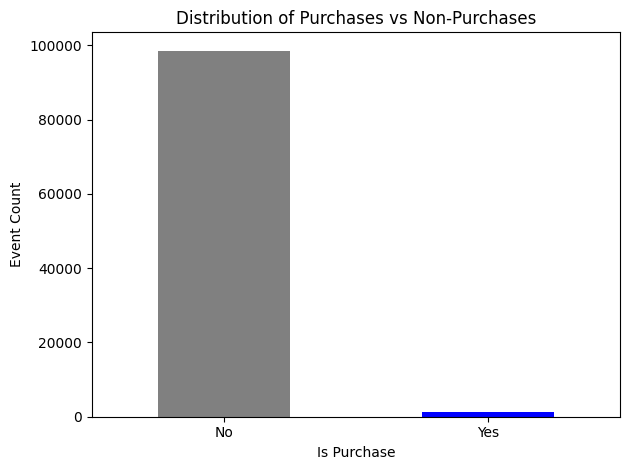

In [60]:
# ─── Purchase Flag Distribution ──────────────────────────────────────────
# Bar chart showing how many events are purchases vs non-purchases
import matplotlib.pyplot as plt

# Count True/False in the 'is_purchase' feature
purchase_counts = df['is_purchase'].value_counts()

plt.figure()
purchase_counts.plot(kind='bar', color=['gray','blue'])
plt.title("Distribution of Purchases vs Non-Purchases")
plt.xlabel("Is Purchase")
plt.ylabel("Event Count")
plt.xticks([0,1], ['No', 'Yes'], rotation=0)
plt.tight_layout()
plt.show()


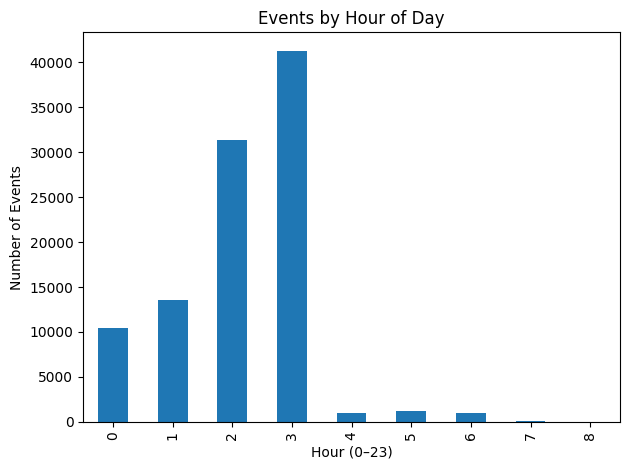

In [63]:
# ─── Events by Hour of Day ───────────────────────────────────────────────
# Bar chart of event volume across each hour to see daily traffic patterns
plt.figure()
df['hour_of_day'].value_counts().sort_index().plot(kind='bar')
plt.title("Events by Hour of Day")
plt.xlabel("Hour (0–23)")
plt.ylabel("Number of Events")
plt.tight_layout()
plt.show()


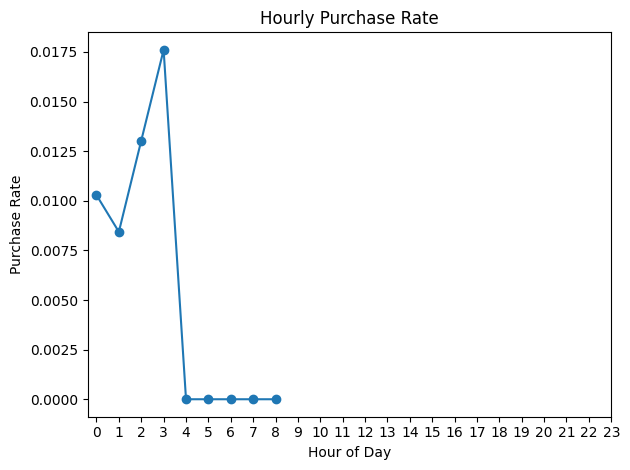

In [64]:
# ─── Purchase Rate by Hour of Day ────────────────────────────────────────
# Line plot of the proportion of events that are purchases, by hour
hourly = df.groupby('hour_of_day')['is_purchase'].mean()

plt.figure()
hourly.plot(marker='o')
plt.title("Hourly Purchase Rate")
plt.xlabel("Hour of Day")
plt.ylabel("Purchase Rate")
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()


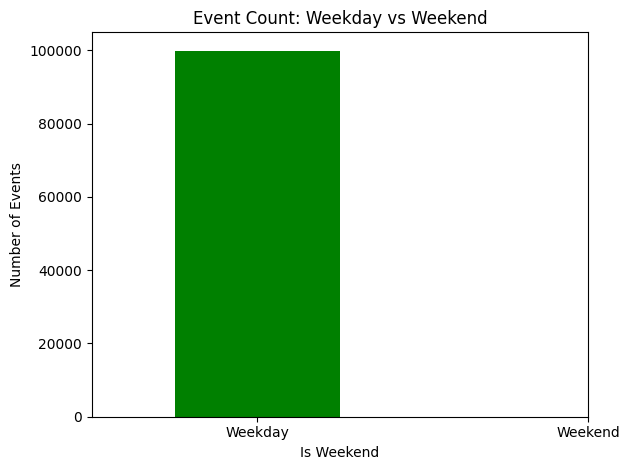

In [66]:
# ─── Weekend vs Weekday Event Counts ────────────────────────────────────
# Compare total events on weekends vs weekdays
counts = df['is_weekend'].value_counts()

plt.figure()
counts.plot(kind='bar', color=['green','orange'])
plt.title("Event Count: Weekday vs Weekend")
plt.xlabel("Is Weekend")
plt.ylabel("Number of Events")
plt.xticks([0,1], ['Weekday','Weekend'], rotation=0)
plt.tight_layout()
plt.show()


## 6  Validation tests

In [ ]:
assert df["price"].min() >= 0, "Negative prices detected!"
if 'quantity' in df.columns:
    assert df['quantity'].min() >= 0, "Negative quantities detected!"
if "duration_s" in df.columns:
    assert (df["duration_s"] >= 0).all(), "Negative session durations!"

print("✅ All validation checks passed.")

## 7  Export cleaned sample

In [ ]:
df.to_csv(CSV_OUT, index=False)
print(f"saved to {CSV_OUT}")